# Delieamento do Estudo

## Estratégia de Análise

**Questões do Estudo**: 
 1. Quais os principais fatores que levam os usuários a converter a compra? 
 2. Podemos prever qual revendedor (se houver) seria escolhido na lista de Ofertas? 

**DataSets**: 

**TreiningSet**

- DealerId              - Identificado único de um revendedor
- Conversion            - Booleano para se o usuário converteu
- long                  - Longitude of the user's location
- lat                   - Latitude of the user's location
- deviceid              - Identificado único do usuario
- EventTimestamp        - O carimbo de data / hora UTC da lista de ofertas
- DealerOpened          - Se o revendedor estava aberto ou fechado. Revendedor - fechados não conseguem vender
- Distributor           - A marca da botija de gás
- Position              - Posição do item na lista
- Quality               - Índice de qualidade com base nas avaliações do usuário
- DealerETAGroup        - O tempo estimado de entrega
- RecommendationType    - Um emblema atribuído para destacar boas ofertas
- Price                 - Preço da botija de gás
- SearchId              - Identificador único da lista de ofertas

**CityState**

- CityId                - Unique city identifier	
- State                 - State name
- City                  - City name
- Geography             - City polygon

## Métodos

<p align = "justify"> Além das estatísticas básicas comumente utilizadas (preço médio, número de revendedores por listagem ...), o objetivo dessa análise foi desenvolver  um modelo preditivo que permitisse identificar os principais fatores que influenciam a decisão do usuário pela compra, assim como, aplica-lo na construção  ranking por revendedores, estimando a  probabilidade de conversão em uma lista. Segue as etapas a serem desenvolvidas: </p>

1. **Importação dos DataSets**: Acessando o BIGQUERY para leitura e importação dos DataSets (TreiningSet e CiyState); 

2. **Merge das TrainingSet e CitySate**: Em ambas tabelas possui um campo de geolocalização: 
    - TrainingSet - Logitude (long) e Latitude (lat)
    - CitySate - Geography (dimensão geográfica por cidade)

  Foi realizado o merge para buscar a cidade de localização do usuário ao acessar o app CHAMA;

3. **Pré-tratamento dos dados**: Verificação de campos nulos, dropando colunas desnecessárias e criando novos atributos (variáveis);

4. **Análise Exploratorio dos Dados**: Explorando a distribuição das variáveis a partir da estrutura definida - Usuário, Revendedor e Lista; 

5. **Preparação dos dados para Modelo (Universo do Estudo - São Paulo)**: O DataSet delineado teve a granulalidade reduzida por lista - SearchId . Sendo assim, todos os atributos relacionados ao revendedor, optou-se por uma métrica estatística adequada para o agrupamento.   

6. **Modelo Preditivo**: Estimação e validação do modelo:
    - Foi solicitado que "NÃO" era necessário treinar o modelo. Entretanto, realizou a segmentação com objetivo mensura a acuraria do modelo proposto, sendo utilizado na sequência, para estimar a probabilidade de conversão do revendedor a ser escolhido em uma lista;  
    



# Importação dos DataSets

## Bibliotecas Importantes

In [1]:
!pip install --upgrade 'google-cloud-bigquery[bqstorage,pandas]'
!pip install geopandas
!pip install shapely
!pip install pygeos
!pip install rtree
!pip3 install rtree
!pip install geopandas
!pip install remodel
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
import geopandas as gpd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from datetime import datetime 
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
import sqlite3 as sql
import sqlite3
import plotly.express as px
from pandas.plotting import scatter_matrix, parallel_coordinates
import os
from statsmodels.tsa.seasonal import seasonal_decompose
import requests
import glob
from bs4 import BeautifulSoup
from requests import get  

     |████████████████████████████████| 994 kB 5.2 MB/s 
     |████████████████████████████████| 6.3 MB 11.7 MB/s 
     |████████████████████████████████| 15.4 MB 37 kB/s 
     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 994 kB 5.2 MB/s 
     |████████████████████████████████| 160 kB 5.3 MB/s 
  Created wheel for remodel: filename=remodel-1.0.0-py3-none-any.whl size=22993 sha256=af5a5bf4ca4dc98c95b6d82ca6bce9af126056f602ef759cbea009aa46e4202c
  Stored in directory: /root/.cache/pip/wheels/c0/4f/fa/a5c4c0d917735c504c1fdbb8ebbb7a8f1eb035cec78e54249c
Successfully built remodel


/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Credenciais no Goolge para acessar o BIGQUERY

A primeira vez que executar o comando abaixo, será necessário clicar no link e copiar a credencias de acesso ao BigQuery


In [2]:
# Autenticação para acessar o BigQuery

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [3]:
# Pacote que pode ser usado para exibir grandes dataframes do pandas como uma tabela de dados

%load_ext google.colab.data_table

Declarando o ID do projeto do Cloud que será usado para acessar os dados

In [4]:
# Declaração do projeto na Cloud e acessando

project_id = 'chama-bi-recruitment'
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

## Importando os conjuntos de dados "TrainingSet" e "CityState"

In [5]:
# Tabela TrainingSet

TrainingSet = client.query('''SELECT * FROM `chama-bi-recruitment.Conversion.TrainingSet`''').to_dataframe()

In [6]:
TrainingSet.shape

(615932, 14)

In [7]:
# Visualizando o conjunto de dados 

TrainingSet.head()

,DealerId,Conversion,long,lat,deviceid,EventTimestamp,DealerOpened,Distributor,Position,Quality,DealerETAGroup,RecommendationType,Price,SearchId
0,__+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=,0,-46.447070,-23.692437,__DgaD5Lhp22YQKyzbqGgd14I77qBO8szy1BHJ+EALcCQ=,2019-07-30 23:08:33.941002+00:00,False,COPAGAZ,7,4.950000,15-30,N/A,69.989998,__DgaD5Lhp22YQKyzbqGgd14I77qBO8szy1BHJ+EALcCQ=...
1,__+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=,0,-46.449238,-23.673485,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=,2019-06-01 17:23:21.881002+00:00,True,COPAGAZ,2,4.840000,15-30,N/A,69.989998,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=...
2,__+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=,0,-46.449238,-23.673485,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=,2019-06-01 21:43:12.103002+00:00,True,COPAGAZ,3,4.840000,15-30,N/A,64.989998,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=...
3,__+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=,0,-46.462443,-23.683456,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=,2019-06-02 16:58:04.585006+00:00,False,COPAGAZ,3,4.846154,15-30,N/A,69.989998,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=...
4,__+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=,0,-46.444472,-23.687698,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=,2019-06-02 17:24:35.304002+00:00,False,COPAGAZ,3,4.846154,15-30,N/A,69.989998,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=...


In [8]:
# Conferindo a Typagem dos atributos 

TrainingSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615932 entries, 0 to 615931
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   DealerId            615932 non-null  object             
 1   Conversion          615932 non-null  int64              
 2   long                615932 non-null  float64            
 3   lat                 615932 non-null  float64            
 4   deviceid            615932 non-null  object             
 5   EventTimestamp      615932 non-null  datetime64[ns, UTC]
 6   DealerOpened        615932 non-null  bool               
 7   Distributor         615932 non-null  object             
 8   Position            615932 non-null  int64              
 9   Quality             615932 non-null  float64            
 10  DealerETAGroup      615932 non-null  object             
 11  RecommendationType  615247 non-null  object             
 12  Price           

In [9]:
# Tabela CityState

CityState= client.query('''SELECT * FROM `chama-bi-recruitment.GeographyBrazil.CityState`''').to_dataframe()

In [10]:
CityState.shape

(5517, 4)

In [11]:
# Visualizando o conjunto de dados CityState

CityState.head(1)

,CityId,State,City,Geography
0,2930,Acre,Rodrigues Alves,"POLYGON((-72.805927 -7.687039, -72.806833 -7.6..."


In [12]:
# Conferindo a Typagem dos atributos 

CityState.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   CityId     5517 non-null   int64 
 1   State      5517 non-null   object
 2   City       5517 non-null   object
 3   Geography  5516 non-null   object
dtypes: int64(1), object(3)
memory usage: 172.5+ KB


In [13]:
# Salvando os conjuntos de dados localmente

TrainingSet.to_csv("TrainingSet.csv")
CityState.to_csv("CityState.csv")

# Merge das TrainingSet e CitySate 

Ambas as tabelas apresentam dados geograficos a serem relacionados, entretanto, para isso sera necessário preparar as chaves de relacionamento de ambas as tabelas: 

- **DataSet TrainingSet** - Longuitude (long) e Latitude (lat) - Será criado um ponto geográrico no conjunto de dados;

- **DataSet CityState** - haverá apenas uma transformação no campo Geography. Será renomeado e tipado como geometrico. 

Observação: Foi utilizado o pacote python "geopandas".



**DataSet TraininSet**

Inserido no conjunto de dados TrainingSet a localização de ponto

In [ ]:
# Definindo o conjunto de dados TrainingSet como GeodataFrame

TrainingSet = geopandas.GeoDataFrame(TrainingSet, geometry=geopandas.points_from_xy(TrainingSet.long, TrainingSet.lat))

In [ ]:
# Visualizando o DataSet TrainingSet

TrainingSet.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 615932 entries, 0 to 615931
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   DealerId            615932 non-null  object             
 1   Conversion          615932 non-null  int64              
 2   long                615932 non-null  float64            
 3   lat                 615932 non-null  float64            
 4   deviceid            615932 non-null  object             
 5   EventTimestamp      615932 non-null  datetime64[ns, UTC]
 6   DealerOpened        615932 non-null  bool               
 7   Distributor         615932 non-null  object             
 8   Position            615932 non-null  int64              
 9   Quality             615932 non-null  float64            
 10  DealerETAGroup      615932 non-null  object             
 11  RecommendationType  615247 non-null  object             
 12  Price   

**DataSet CityState**

In [ ]:
# Definindo o conjunto de dados CityState como GeodataFrame

CityState = geopandas.GeoDataFrame(CityState)

In [ ]:
# Definindo o ponto geográfico 

CityState = CityState.rename(columns={'Geography':'geometry'})
CityState['geometry'] = gpd.GeoSeries.from_wkt(CityState['geometry'])

In [ ]:
# Visualizando a type das tabela

CityState.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   CityId    5517 non-null   int64   
 1   State     5517 non-null   object  
 2   City      5517 non-null   object  
 3   geometry  5516 non-null   geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 172.5+ KB


In [ ]:
# Visualizando o conjunto de dados 

CityState.head(2)

,CityId,State,City,geometry
0,2930,Acre,Rodrigues Alves,"POLYGON ((-72.80593 -7.68704, -72.80683 -7.686..."
1,2920,Acre,Jordão,"POLYGON ((-71.55530 -8.64739, -71.56645 -8.647..."


**Merge das Tabelas TraininSet x CityState

In [ ]:
# Dataframe após merge das tabealas

df = geopandas.sjoin(TrainingSet,CityState, how="left", op='intersects')

In [ ]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 615932 entries, 0 to 615931
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   DealerId            615932 non-null  object             
 1   Conversion          615932 non-null  int64              
 2   long                615932 non-null  float64            
 3   lat                 615932 non-null  float64            
 4   deviceid            615932 non-null  object             
 5   EventTimestamp      615932 non-null  datetime64[ns, UTC]
 6   DealerOpened        615932 non-null  bool               
 7   Distributor         615932 non-null  object             
 8   Position            615932 non-null  int64              
 9   Quality             615932 non-null  float64            
 10  DealerETAGroup      615932 non-null  object             
 11  RecommendationType  615247 non-null  object             
 12  Price   

# Pré-tratamento dos dados

Dropando Missing

Ao analisar a função seguir, nota-se valor nulos na variáveis RecomendationTypy e com atributos relacionado do dataset CitySate. Nesses casos, decidiu-se pela exclusão das linhas com valores nulos.

In [ ]:
# Verificando a frequência com valores nulos

df.isna().sum()

DealerId                0
Conversion              0
long                    0
lat                     0
deviceid                0
EventTimestamp          0
DealerOpened            0
Distributor             0
Position                0
Quality                 0
DealerETAGroup          0
RecommendationType    685
Price                   0
SearchId                0
geometry                0
index_right            85
CityId                 85
State                  85
City                   85
dtype: int64

In [ ]:
# dropando todas as linhas com valores nulos

df.dropna(inplace=True) 

In [ ]:
df.isna().sum()

DealerId              0
Conversion            0
long                  0
lat                   0
deviceid              0
EventTimestamp        0
DealerOpened          0
Distributor           0
Position              0
Quality               0
DealerETAGroup        0
RecommendationType    0
Price                 0
SearchId              0
geometry              0
index_right           0
CityId                0
State                 0
City                  0
dtype: int64

In [ ]:
# Visualizando o DataFrame 

df.head()

,DealerId,Conversion,long,lat,deviceid,EventTimestamp,DealerOpened,Distributor,Position,Quality,DealerETAGroup,RecommendationType,Price,SearchId,geometry,index_right,CityId,State,City
0,__+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=,0,-46.447070,-23.692437,__DgaD5Lhp22YQKyzbqGgd14I77qBO8szy1BHJ+EALcCQ=,2019-07-30 23:08:33.941002+00:00,False,COPAGAZ,7,4.950000,15-30,N/A,69.989998,__DgaD5Lhp22YQKyzbqGgd14I77qBO8szy1BHJ+EALcCQ=...,POINT (-46.44707 -23.69244),2418.0,326.0,Sao Paulo,Mauá
1,__+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=,0,-46.449238,-23.673485,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=,2019-06-01 17:23:21.881002+00:00,True,COPAGAZ,2,4.840000,15-30,N/A,69.989998,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=...,POINT (-46.44924 -23.67348),2418.0,326.0,Sao Paulo,Mauá
2,__+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=,0,-46.449238,-23.673485,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=,2019-06-01 21:43:12.103002+00:00,True,COPAGAZ,3,4.840000,15-30,N/A,64.989998,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=...,POINT (-46.44924 -23.67348),2418.0,326.0,Sao Paulo,Mauá
3,__+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=,0,-46.462443,-23.683456,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=,2019-06-02 16:58:04.585006+00:00,False,COPAGAZ,3,4.846154,15-30,N/A,69.989998,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=...,POINT (-46.46244 -23.68346),2418.0,326.0,Sao Paulo,Mauá
4,__+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=,0,-46.444472,-23.687698,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=,2019-06-02 17:24:35.304002+00:00,False,COPAGAZ,3,4.846154,15-30,N/A,69.989998,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=...,POINT (-46.44447 -23.68770),2418.0,326.0,Sao Paulo,Mauá


In [ ]:
# removendo algumas colunas 

cols_to_drop = ["long","lat","index_right","CityId"]
df = df.drop(cols_to_drop, axis=1)

## Tratando EventTimestamp

Essa variável representa a data da lista ofertada. Nesse primeiro momento, será criado algumas variaveis derivadas da data que pode ser utilizada posteriormente. 

In [ ]:
# Criando as variáveis "Dia_da_semana", "dia_mes", "mes", "ano" e "hora" respectivamente

#date = datetime.strptime(str_date, '%d/%m/%Y').date()
df['date'] = df['EventTimestamp'].dt.strftime('%d/%m/%Y')
df['dia_da_semana'] = df['EventTimestamp'].dt.strftime("%A")
df['dia_mes'] = df['EventTimestamp'].dt.strftime("%d")
df['mes'] = df['EventTimestamp'].dt.strftime("%B")
df['ano'] = df['EventTimestamp'].dt.year
df['hora'] = df['EventTimestamp'].dt.strftime("%H")

In [ ]:
df.head()

,DealerId,Conversion,deviceid,EventTimestamp,DealerOpened,Distributor,Position,Quality,DealerETAGroup,RecommendationType,Price,SearchId,geometry,State,City,date,dia_da_semana,dia_mes,mes,ano,hora
0,__+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=,0,__DgaD5Lhp22YQKyzbqGgd14I77qBO8szy1BHJ+EALcCQ=,2019-07-30 23:08:33.941002+00:00,False,COPAGAZ,7,4.950000,15-30,N/A,69.989998,__DgaD5Lhp22YQKyzbqGgd14I77qBO8szy1BHJ+EALcCQ=...,POINT (-46.44707 -23.69244),Sao Paulo,Mauá,30/07/2019,Tuesday,30,July,2019,23
1,__+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=,0,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=,2019-06-01 17:23:21.881002+00:00,True,COPAGAZ,2,4.840000,15-30,N/A,69.989998,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=...,POINT (-46.44924 -23.67348),Sao Paulo,Mauá,01/06/2019,Saturday,01,June,2019,17
2,__+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=,0,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=,2019-06-01 21:43:12.103002+00:00,True,COPAGAZ,3,4.840000,15-30,N/A,64.989998,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=...,POINT (-46.44924 -23.67348),Sao Paulo,Mauá,01/06/2019,Saturday,01,June,2019,21
3,__+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=,0,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=,2019-06-02 16:58:04.585006+00:00,False,COPAGAZ,3,4.846154,15-30,N/A,69.989998,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=...,POINT (-46.46244 -23.68346),Sao Paulo,Mauá,02/06/2019,Sunday,02,June,2019,16
4,__+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=,0,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=,2019-06-02 17:24:35.304002+00:00,False,COPAGAZ,3,4.846154,15-30,N/A,69.989998,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=...,POINT (-46.44447 -23.68770),Sao Paulo,Mauá,02/06/2019,Sunday,02,June,2019,17


# Análise Exploratorio dos Dados

<p align = "justify"> Esta seção apresenta algumas estatísticas relacionadas às três dimensões da granularidade do DataFrame (usuário, revendedor e lista de cotações). O objetivo principal é entender a distribuição de atributos de forma granular por meio de análises exploratórias e comparar as informações com variáveis ​​de "transformação" quando possível.</p>

**Dados do Usuário**

- long                  - Longitude of the user's location
- lat                   - Latitude of the user's location
- deviceid              - Identificado único do usuario

**Dados do Revendedor**-

- DealerId              - Identificado único de um revendedor
- DealerOpened          - Se o revendedor estava aberto ou fechado. Revendedor - fechados não conseguem vender
- Distributor           - A marca da garrafa de gás
- Position              - Posição do item na lista
- Quality               - Índice de qualidade com base nas avaliações do usuário
- DealerETAGroup        - O tempo estimado de entrega
- RecommendationType    - Um emblema atribuído para destacar boas ofertas
- Price                 - Preço da garrafa de gás

**Dados da Lista**

- SearchId              - Identificador único da lista de ofertas
- EventTimestamp        - O carimbo de data / hora UTC da lista de ofertas
- Conversion            - Booleano para se o usuário converteu

### Dados do Usuário

deviceid

No geral, do conjunto de dados tem 19472 usuarios que utilizadaram aplicativos. Na tabela a seguir, é possível verificar a quantidade de conversões (compras) por usuários.

In [ ]:
# Criando uma tabela auxiliar por usuário
dfus = df.groupby(['deviceid','State','City'], as_index=False)
dfus = dfus.agg({'Conversion':'sum','date':'min'})
dfus.columns = list(map(''.join, dfus .columns.values))

In [ ]:
dfus

Analisando a tabela abaixo, evidencia que quase 14% dos usuarios fizeram compras no app. 

In [ ]:
# Distribuição dos usuários por quantidade de conversão. 
dfus.Conversion.value_counts(normalize=True)

0    0.864972
1    0.133124
2    0.001853
4    0.000051
Name: Conversion, dtype: float64

In [ ]:
# Substituindo conversões 2 e 4 por 1 no conjunto de dados principal (df)

df.Conversion.replace(2, 1, inplace=True)
df.Conversion.replace(4, 1, inplace=True)
df.Conversion.replace(3, 1, inplace=True)
df.Conversion.value_counts(normalize=True)

0    0.995671
1    0.004329
Name: Conversion, dtype: float64

Cerca 82,34% dos usuários estão localizados no estado de São Paulo

In [ ]:
# Distribuição dos usuários por estado 
dfus.State.value_counts(normalize=True)

Sao Paulo            0.823650
Minas Gerais         0.106829
Rio Grande do Sul    0.051459
Paraná               0.014151
Distrito Federal     0.003911
Name: State, dtype: float64

In [ ]:
# Criando variáveis binarias no conjunto de dados transformado (dft)
dft = df
#dft = pd.get_dummies(df, columns = ['State'])

42,38% dos clientes estão localizado no municipio de São Paulo, no geral 27 cidades representam quase 98% dos usuários do conjunto de dados analisando. 

In [ ]:
# Distribuição dos usuários por Cidade
dfus_cid = pd.DataFrame(dfus.City.value_counts(normalize=True))
dfus_cid  = dfus_cid.sort_values(by='City',ascending=False)
dfus_cid["cumpercentage"] = dfus_cid["City"].cumsum()/dfus_cid["City"].sum()*100

No handles with labels found to put in legend.


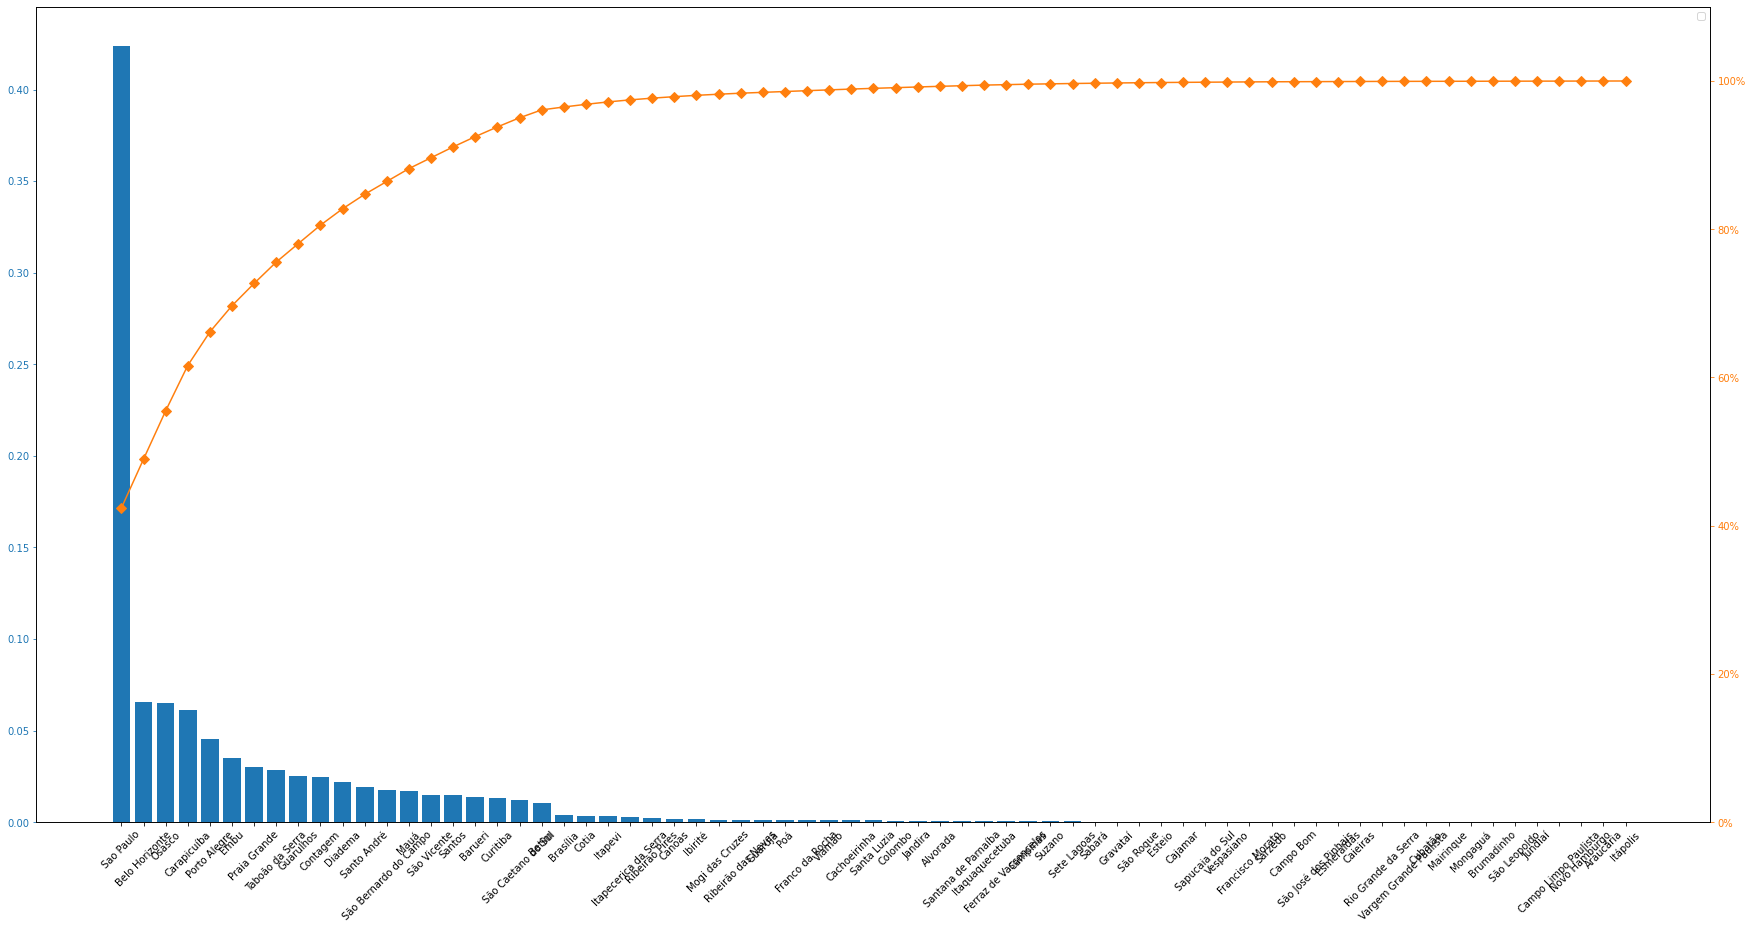

In [ ]:
# Gerando o gráfico de paretro com distribuição de usuários por Cidade

from matplotlib.ticker import PercentFormatter

fig, ax = plt.subplots(figsize=(30,15))
ax.bar(dfus_cid.index, dfus_cid["City"], color="C0")
ax2 = ax.twinx()
ax2.plot(dfus_cid.index, dfus_cid["cumpercentage"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

# Configurações dos eixos 
ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
ax2.set_ylim([0,110])

# Ajusta a inclinação dos labels do eixo x
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# Finalmente mostra o grafico definido acima
plt.legend() 
plt.show()


In [ ]:
dfus_cid

,City,cumpercentage
Sao Paulo,0.423918,42.391808
Belo Horizonte,0.065867,48.978542
Osasco,0.065147,55.493233
Carapicuíba,0.061236,61.616837
Porto Alegre,0.045335,66.150363
...,...,...
Jundiaí,0.000051,99.979416
Campo Limpo Paulista,0.000051,99.984562
Novo Hamburgo,0.000051,99.989708
Araucária,0.000051,99.994854


### Dados do Revendedor

Nessa etapa os revendedores serão agrupados por estado, para entendimento do perfil e preços médio praticados nas listas ofertadas.

No caso dos revendedores, tem três variáveis que pode haver alterações de uma anuncio (lista) para outro. Nesta analise de revendedores, serão deixadas de fora, mas na sequência, transformadas em variáveis binarias no dataframe transformação (dft).


In [ ]:
# Criando uma tabela auxiliar por revendedor

dfrev= df.groupby(['DealerId',"State"], as_index=False)
dfrev= dfrev.agg({'Conversion':'sum',
                  'date':'min',
                  'Price':["mean"],
                  'Quality':["mean"],
                  'Position':["mean"]})
dfrev.columns = list(map(''.join, dfrev.columns.values))


 No geral, no conjunto de dados têm 1834 revendedores. 

In [ ]:
dfrev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1834 entries, 0 to 1833
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DealerId       1834 non-null   object 
 1   State          1834 non-null   object 
 2   Conversionsum  1834 non-null   int64  
 3   datemin        1834 non-null   object 
 4   Pricemean      1834 non-null   float64
 5   Qualitymean    1834 non-null   float64
 6   Positionmean   1834 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 114.6+ KB


In [ ]:
dfrev.head()

,DealerId,State,Conversionsum,datemin,Pricemean,Qualitymean,Positionmean
0,__+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=,Sao Paulo,0,01/06/2019,69.667475,4.920091,4.712032
1,__+8XmsU3LLXtVj5SyXHYY0D64RynJANGeifXDiUFzDc8=,Minas Gerais,0,01/06/2019,80.000000,4.882759,6.724138
2,__+AX16Klw83OSwUSI3XJu71zUjBYvgWx6cTReL4VTbRE=,Minas Gerais,0,01/07/2019,84.619375,5.000000,8.531250
3,__+FOaLWh6YMAqnXW3e2ksrWs8n24EwmkNZNefrpfdBxI=,Sao Paulo,0,01/06/2019,66.496094,4.590402,3.765625
4,__+Ggvnlp+IvfHyK2PxT2NBIhYNuwl5yzEJzPjSjI04AQ=,Minas Gerais,0,01/06/2019,83.000000,4.200000,9.752161


Como era de espera, a maioria dos revendedores são do estado de São Paulo (80%). 

In [ ]:
# Distribuição dos revendedores por estado 

dfrev.State.value_counts(normalize=True)

Sao Paulo            0.799891
Minas Gerais         0.101963
Rio Grande do Sul    0.045802
Paraná               0.035442
Distrito Federal     0.016903
Name: State, dtype: float64

A tabela a seguir, expoe a distribuição média dos preço por estado. A maior média observada foi identificada no Distrito Federal, com preço médio de R\$ 74,55, sendo seguido por São Paulo com preço médio de R\$ 73,78. 

In [ ]:
# Estatística descritiva por estado (Preço)

resumo = dfrev.groupby('State').agg({'Pricemean':['mean','std', 'min','median','max','count']})
resumo

Pricemean                                                  
                        mean       std        min     median         max count
State                                                                         
Distrito Federal   74.551802  7.892131  60.000000  72.000000   92.083333    31
Minas Gerais       73.228410  4.902978  64.603522  72.464673   89.000000   187
Paraná             72.427130  4.368684  64.978571  71.500000   84.998125    65
Rio Grande do Sul  72.597566  4.066296  66.337391  71.816421   84.002397    84
Sao Paulo          73.784913  6.972647  23.300000  72.780440  120.000000  1467

Ao analisar o número medio de conversão (total de conversão), nota-se uma maior média no estado do Rio Grande do Sul. Em todos os estados, 50% dos revendedores não tiveram conversão de vendas. 

In [ ]:
# Estatística descritiva por estado (Conversion)

resumo = dfrev.groupby('State').agg({'Conversionsum':['mean','std', 'min','median','max','count']})
resumo

Conversionsum                               
                           mean       std min median max count
State                                                         
Distrito Federal       0.193548  0.401610   0      0   1    31
Minas Gerais           1.347594  2.720300   0      0  18   187
Paraná                 0.492308  1.404491   0      0   9    65
Rio Grande do Sul      2.071429  4.433676   0      0  19    84
Sao Paulo              1.498978  3.119357   0      0  36  1467

A matriz de correlação abaixo exibe os coeficientes de correlação dos indicadores por revendedor, nota-se que: 

- a maior correlação absoluta observada foi entre preço (Pricemean) e total de conversão (Conversionsum), indicando quanto menor o preço praticado pelo revendendor maior o número de conversões. 
- A variável "Quality", apresentou uma correlação fraca com conversão, mas sinal positivo. Isso pressupoe que, quanto maior for avaliação do revendedor mais ele converte venda. 
- o indicador position, e altamente correlacionado com preço. A correlação dessa variável com total de conversão (ConvesionSum) tambem foi negativa. 

In [ ]:
dfrev.corr()

,Conversionsum,Pricemean,Qualitymean,Positionmean
Conversionsum,1.000000,-0.232881,0.053828,-0.094913
Pricemean,-0.232881,1.000000,-0.019942,0.438278
Qualitymean,0.053828,-0.019942,1.000000,-0.148044
Positionmean,-0.094913,0.438278,-0.148044,1.000000


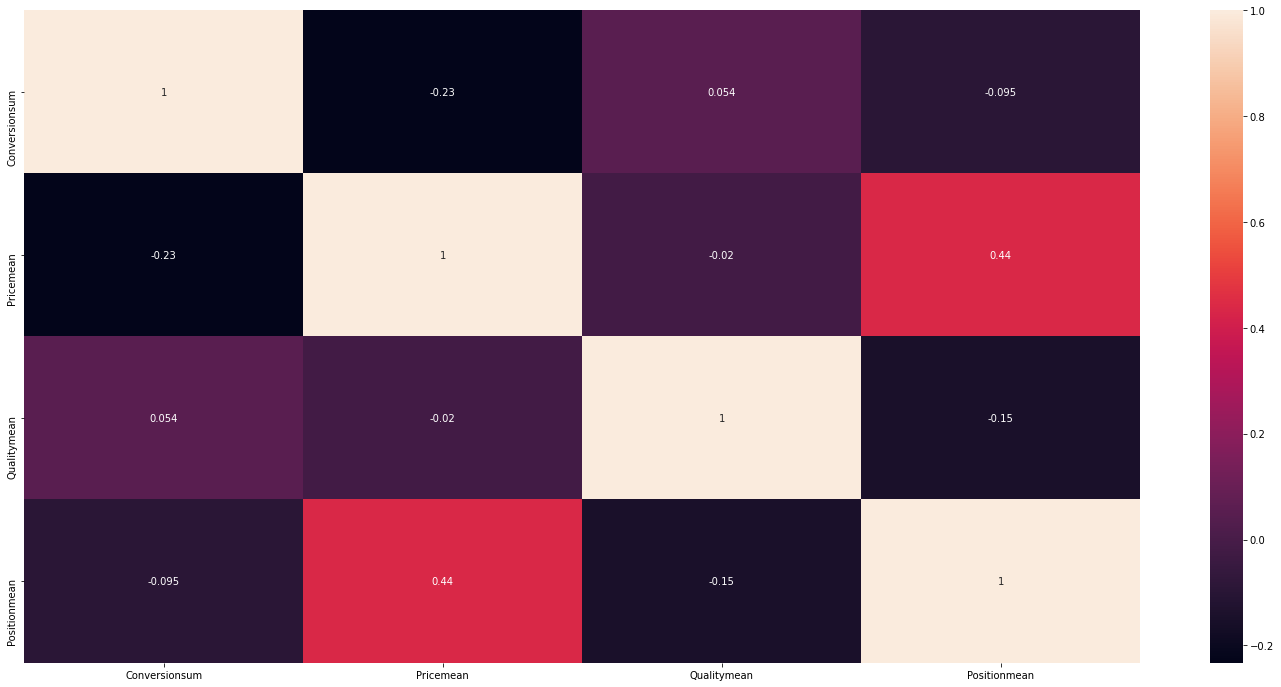

In [ ]:
# Matriz de correlação 

plt.figure(figsize=(25,12))
p = sns.heatmap(data=dfrev.corr(method='pearson'), annot=True)

 Transformação Binarias das variáveis para base do modelo preditivo: 
 
- DealerETAGroup
- RecommendationType 

In [ ]:
dft = pd.get_dummies(dft, columns = ['DealerETAGroup','Distributor','RecommendationType'])

### Dados da Lista

A ideia nessa etapa é semelhante ao que se fez na seção "Dados do Revendedor". Inicialmente, criar uma tabela com as listas e respectivas média de preços, quality e posição, além de avaliar a distribuição das listas por estado. 

In [ ]:
# Criando uma tabela auxiliar das Listas
dflist= df.groupby(['SearchId',"State","date","dia_da_semana","dia_mes","mes","hora","ano"], as_index=False)
dflist= dflist.agg({'Conversion':'sum',
                  'Price':["mean"],
                  'Quality':["mean"],
                  'Position':["mean"]})
dflist.columns = list(map(''.join, dflist.columns.values))

In [ ]:
dflist.head()

,SearchId,State,date,dia_da_semana,dia_mes,mes,hora,ano,Conversionsum,Pricemean,Qualitymean,Positionmean
0,__++NJUeirtx5aLEGXp/83/0gJ7UtC4vhTzoEVtoNOQt4=...,Sao Paulo,24/08/2019,Saturday,24,August,14,2019,0,72.971000,4.730000,4.5
1,__++T9Zhx4sTzT4q3MVRejipG2RSY+lDK4xHAHCn929ls=...,Rio Grande do Sul,12/06/2019,Wednesday,12,June,22,2019,1,71.999000,4.560000,4.5
2,__++T9Zhx4sTzT4q3MVRejipG2RSY+lDK4xHAHCn929ls=...,Rio Grande do Sul,25/06/2019,Tuesday,25,June,21,2019,1,70.066000,4.600000,4.5
3,__++ZUTc6QzI0LR1zqWhO+mrFOdTYTxjtoCx/1u00zGUA=...,Sao Paulo,05/07/2019,Friday,05,July,19,2019,1,71.435556,4.500000,13.0
4,__++c79jNZqUobJxlJ3btmFMU2aiN08U/GsIMl08qWm84=...,Rio Grande do Sul,28/06/2019,Friday,28,June,14,2019,0,71.652857,4.585714,3.0


In [ ]:
dflist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40656 entries, 0 to 40655
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SearchId       40656 non-null  object 
 1   State          40656 non-null  object 
 2   date           40656 non-null  object 
 3   dia_da_semana  40656 non-null  object 
 4   dia_mes        40656 non-null  object 
 5   mes            40656 non-null  object 
 6   hora           40656 non-null  object 
 7   ano            40656 non-null  int64  
 8   Conversionsum  40656 non-null  int64  
 9   Pricemean      40656 non-null  float64
 10  Qualitymean    40656 non-null  float64
 11  Positionmean   40656 non-null  float64
dtypes: float64(3), int64(2), object(7)
memory usage: 4.0+ MB


Frequência de Lista por Estado

In [ ]:
# Distribuição das listas por estado 
dflist.State.value_counts(normalize=True)

Sao Paulo            0.780229
Minas Gerais         0.144284
Rio Grande do Sul    0.062574
Paraná               0.010552
Distrito Federal     0.002361
Name: State, dtype: float64

**Preço Médio** - Estatística descritivas das Listas por estado

In [ ]:
# Estatística descritiva por estado (Preço) por Lista
resumo = dflist.groupby('State').agg({'Pricemean':['mean','std', 'min','median','max','count']})
resumo

Pricemean                                                  
                        mean       std        min     median        max  count
State                                                                         
Distrito Federal   80.814265  6.008394  72.856429  81.642500  95.500000     96
Minas Gerais       72.904586  1.795835  67.083000  73.072679  81.747500   5866
Paraná             75.157556  2.029015  68.966667  75.369000  79.422222    429
Rio Grande do Sul  71.540786  2.128731  65.393333  71.288889  79.000000   2544
Sao Paulo          73.928033  5.050188  40.956000  72.878421  95.963333  31721

**Conversion** - Estatística descritivas das Listas por estado

In [ ]:
# Estatística descritiva por estado (Conversion) por Lista
resumo = dflist.groupby('State').agg({'Conversionsum':['mean','std', 'min','median','max','count']})
resumo

Conversionsum                                
                           mean       std min median max  count
State                                                          
Distrito Federal       0.062500  0.243332   0      0   1     96
Minas Gerais           0.042959  0.202783   0      0   1   5866
Paraná                 0.074592  0.263039   0      0   1    429
Rio Grande do Sul      0.068396  0.252474   0      0   1   2544
Sao Paulo              0.069323  0.254379   0      0   2  31721

In [ ]:
dflist.head()

,SearchId,State,date,dia_da_semana,dia_mes,mes,hora,ano,Conversionsum,Pricemean,Qualitymean,Positionmean
0,__++NJUeirtx5aLEGXp/83/0gJ7UtC4vhTzoEVtoNOQt4=...,Sao Paulo,24/08/2019,Saturday,24,August,14,2019,0,72.971000,4.730000,4.5
1,__++T9Zhx4sTzT4q3MVRejipG2RSY+lDK4xHAHCn929ls=...,Rio Grande do Sul,12/06/2019,Wednesday,12,June,22,2019,1,71.999000,4.560000,4.5
2,__++T9Zhx4sTzT4q3MVRejipG2RSY+lDK4xHAHCn929ls=...,Rio Grande do Sul,25/06/2019,Tuesday,25,June,21,2019,1,70.066000,4.600000,4.5
3,__++ZUTc6QzI0LR1zqWhO+mrFOdTYTxjtoCx/1u00zGUA=...,Sao Paulo,05/07/2019,Friday,05,July,19,2019,1,71.435556,4.500000,13.0
4,__++c79jNZqUobJxlJ3btmFMU2aiN08U/GsIMl08qWm84=...,Rio Grande do Sul,28/06/2019,Friday,28,June,14,2019,0,71.652857,4.585714,3.0


**Analise Temporal**

In [ ]:
dflist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40656 entries, 0 to 40655
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SearchId       40656 non-null  object 
 1   State          40656 non-null  object 
 2   date           40656 non-null  object 
 3   dia_da_semana  40656 non-null  object 
 4   dia_mes        40656 non-null  object 
 5   mes            40656 non-null  object 
 6   hora           40656 non-null  object 
 7   ano            40656 non-null  int64  
 8   Conversionsum  40656 non-null  int64  
 9   Pricemean      40656 non-null  float64
 10  Qualitymean    40656 non-null  float64
 11  Positionmean   40656 non-null  float64
dtypes: float64(3), int64(2), object(7)
memory usage: 5.3+ MB


**Mês** - Distribuições das Listas

In [ ]:
dflist['date'] = pd.to_datetime(dflist['date'])

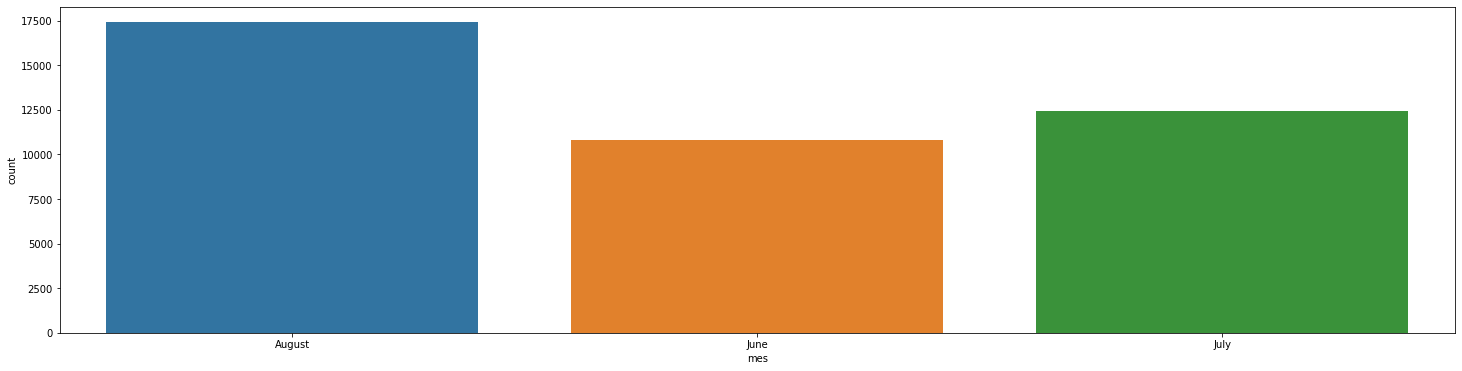

Tabela de Dupla entrada - Conversion x Mês
mes                August        July        June         All
Conversionsum                                                
0               91.576227   95.296573   94.370247   93.457300
1                8.418030    4.687375    5.629753    6.535321
2                0.005742    0.016053    0.000000    0.007379
All            100.000000  100.000000  100.000000  100.000000


In [ ]:
plt.figure(figsize=(25,6))
sns.countplot(x='mes', data=dflist)
plt.show()
print("Tabela de Dupla entrada - Conversion x Mês")
tab = pd.crosstab(index=[dflist["Conversionsum"]],columns=dflist["mes"],margins=True)
print(100*(tab/tab.loc['All']))

**Dia_mês** - Distribuição das Listas

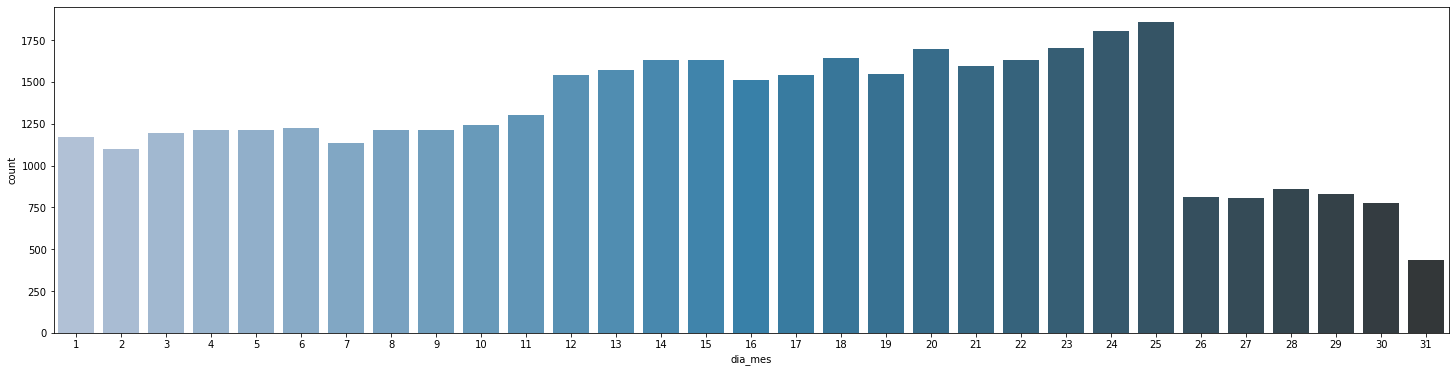

Tabela de Dupla entrada - Conversion x Mês
Conversionsum         0         1         2  All
dia_mes                                         
1              0.943734  0.056266  0.000000  1.0
2              0.950954  0.049046  0.000000  1.0
3              0.947324  0.052676  0.000000  1.0
4              0.949628  0.050372  0.000000  1.0
5              0.959504  0.040496  0.000000  1.0
6              0.951837  0.048163  0.000000  1.0
7              0.949824  0.050176  0.000000  1.0
8              0.951240  0.048760  0.000000  1.0
9              0.966200  0.033800  0.000000  1.0
10             0.953339  0.046661  0.000000  1.0
11             0.947086  0.052914  0.000000  1.0
12             0.918884  0.081116  0.000000  1.0
13             0.918523  0.081477  0.000000  1.0
14             0.909425  0.090575  0.000000  1.0
15             0.909258  0.090742  0.000000  1.0
16             0.913964  0.086036  0.000000  1.0
17             0.913692  0.086308  0.000000  1.0
18             0.923966  0

In [ ]:
dflist['dia_mes'] = dflist['dia_mes'].astype(int)
plt.figure(figsize=(25,6))
sns.countplot(x='dia_mes', data=dflist,palette="PuBu_d")
plt.show()
print("Tabela de Dupla entrada - Conversion x Mês")
tab = pd.crosstab(index=[dflist["dia_mes"]],columns=dflist["Conversionsum"],margins=True)
print(tab.div(tab["All"], axis=0))

**Dia_da_semana** - Distribuição das Listas

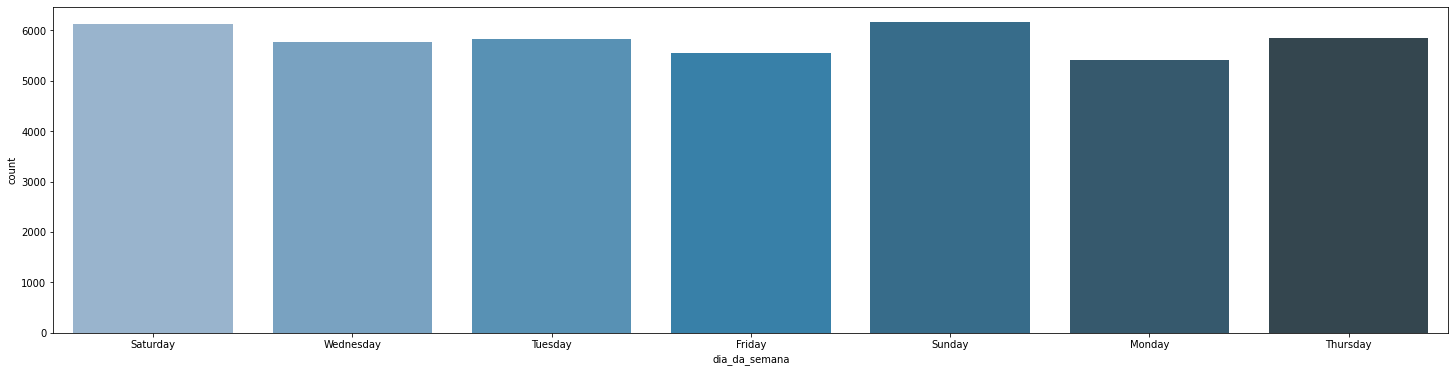

Tabela de Dupla entrada - Conversion x dia da Semana
Conversionsum         0         1         2  All
dia_da_semana                                   
Friday         0.937004  0.062996  0.000000  1.0
Monday         0.933075  0.066741  0.000185  1.0
Saturday       0.928513  0.071324  0.000163  1.0
Sunday         0.934535  0.065465  0.000000  1.0
Thursday       0.937938  0.062062  0.000000  1.0
Tuesday        0.933666  0.066334  0.000000  1.0
Wednesday      0.937630  0.062196  0.000174  1.0
All            0.934573  0.065353  0.000074  1.0


In [ ]:
#dflist['dia_mes'] = dflist['dia_mes'].astype(int)
plt.figure(figsize=(25,6))
sns.countplot(x='dia_da_semana', data=dflist,palette="PuBu_d")
plt.show()
print("Tabela de Dupla entrada - Conversion x dia da Semana")
tab = pd.crosstab(index=[dflist["dia_da_semana"]],columns=dflist["Conversionsum"],margins=True)
print(tab.div(tab["All"], axis=0))

**Hora do dia** - Distribuição das Listas

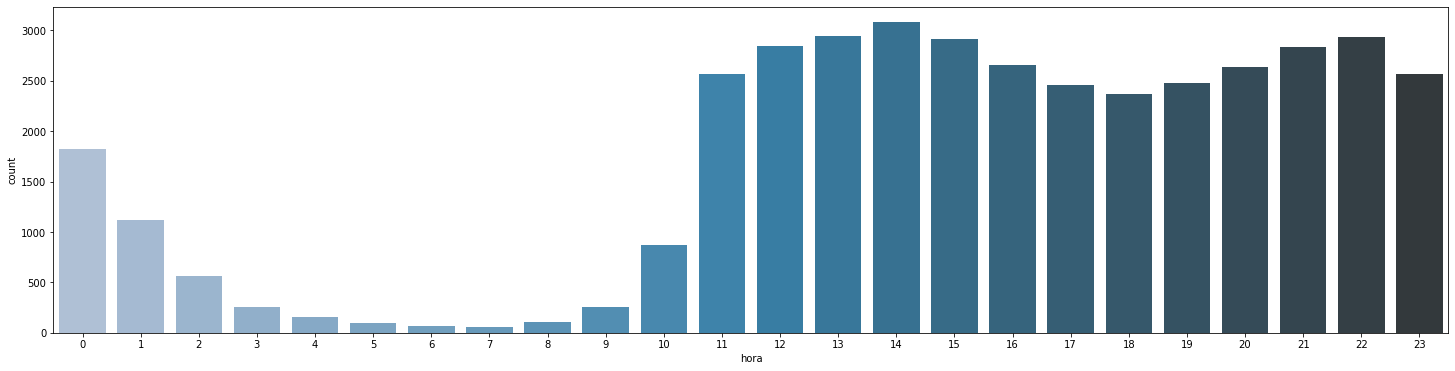

Tabela de Dupla entrada - Conversion x hora
Conversionsum         0         1         2  All
hora                                            
0              0.952721  0.047279  0.000000  1.0
1              0.982990  0.017010  0.000000  1.0
2              0.982301  0.017699  0.000000  1.0
3              1.000000  0.000000  0.000000  1.0
4              1.000000  0.000000  0.000000  1.0
5              1.000000  0.000000  0.000000  1.0
6              1.000000  0.000000  0.000000  1.0
7              0.983871  0.016129  0.000000  1.0
8              1.000000  0.000000  0.000000  1.0
9              0.988462  0.011538  0.000000  1.0
10             0.954023  0.045977  0.000000  1.0
11             0.950992  0.049008  0.000000  1.0
12             0.945794  0.054206  0.000000  1.0
13             0.938817  0.061183  0.000000  1.0
14             0.925000  0.075000  0.000000  1.0
15             0.909622  0.090378  0.000000  1.0
16             0.919519  0.080105  0.000376  1.0
17             0.937704  

In [ ]:
dflist['hora'] = dflist['hora'].astype(int)
plt.figure(figsize=(25,6))
sns.countplot(x='hora', data=dflist,palette="PuBu_d")
plt.show()
print("Tabela de Dupla entrada - Conversion x hora")
tab = pd.crosstab(index=[dflist["hora"]],columns=dflist["Conversionsum"],margins=True)
print(tab.div(tab["All"], axis=0))

Transformação Binarias das variáveis:

- dia_da_semana
- dia_mes
- hora

In [ ]:
dft = pd.get_dummies(dft, columns = ['dia_da_semana','dia_mes','hora'])

In [ ]:
dft.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 615162 entries, 0 to 615931
Data columns (total 94 columns):
 #   Column                                     Non-Null Count   Dtype              
---  ------                                     --------------   -----              
 0   DealerId                                   615162 non-null  object             
 1   Conversion                                 615162 non-null  int64              
 2   deviceid                                   615162 non-null  object             
 3   EventTimestamp                             615162 non-null  datetime64[ns, UTC]
 4   DealerOpened                               615162 non-null  bool               
 5   Position                                   615162 non-null  int64              
 6   Quality                                    615162 non-null  float64            
 7   Price                                      615162 non-null  float64            
 8   SearchId                  

# Preparação dos dados para Modelo

Ao analisar as listas, nota-se que em uma lista poderá haver uma única conversão. Assim, a base de estudo para avaliar os fatores que influenciam a conversão das vendas, será a partir da tabela agrupada por lista.

## Seleção Estado de São Paulo

In [ ]:
# Selecionando apenas as listas de usuários do Estado de São Paulo

dft =  dft[dft['State']=='Sao Paulo']

### Agrupando o DataFrame por Lista

In [ ]:
# Criando o preco de conversão apenas na linhas com Conversion = 1

def conv(dft):
    conv = dft['Conversion']  
    if conv == 1: return dft["Price"]
    return 0
dft['Price_conv'] = dft.apply(conv, axis=1)


In [ ]:
# Criando o quality de conversão apenas na linhas com Conversion = 1

def conv(dft):
    conv = dft['Conversion']  
    if conv == 1: return dft["Quality"]
    return 0
dft['Quality_conv'] = dft.apply(conv, axis=1)


In [ ]:
# Visualiando todo o conjunto de dados 

pd.set_option('display.max_columns', len(dft.columns)) # Exibinndo todas as colunas do dft
pd.set_option('display.max_rows', 100)
dft.head(5)

In [ ]:
# Criando uma tabela auxiliar das Listas

dfmod1= dft.groupby(['SearchId'], as_index=False)
dfmod1= dfmod1.agg(n_rev = ("DealerId",'count'),
                  target_conv=('Conversion',max),
                  preco_conv =('Price_conv','max'),
                  preco_medio=('Price','mean'),
                  amplitude_preco=('Price', lambda x: max(x)-min(x)),
                  quality_conv =('Quality_conv','max'),
                  quality_medio=('Quality','mean'),
                  amplitude_quality=('Quality', lambda x: max(x)-min(x)),
                  mean_DealerETAGroup_10_15=('DealerETAGroup_10-15','mean'),
                  mean_DealerETAGroup_15_30=('DealerETAGroup_15-30','mean'),
                  mean_DealerETAGroup_30_45=('DealerETAGroup_30-45','mean'),
                  mean_DealerETAGroup_45_60=('DealerETAGroup_45-60','mean'), 
                  mean_CONSIGAZ =('Distributor_CONSIGAZ','mean'), 
				          mean_COPAGAZ =('Distributor_COPAGAZ','mean'),
				          mean_LIQUIGAS =('Distributor_LIQUIGAS','mean'),
				          mean_MULTIMARCAS =('Distributor_MULTIMARCAS','mean'),
                  mean_NACIONALGAS =('Distributor_NACIONALGAS','mean'),
                  mean_SUPERGASBRAS=('Distributor_SUPERGASBRAS','mean'),
                  mean_ULTRAGAZ=('Distributor_ULTRAGAZ','mean'),
                  mean_BestDeal=('RecommendationType_BestDeal','mean'),
                  mean_BestPrice=('RecommendationType_BestPrice','mean'),
                  mean_BestPrice_MobileDealer=('RecommendationType_BestPrice,MobileDealer','mean'),
                  mean_MobileDealer =('RecommendationType_MobileDealer','mean'),
                  mean_N_A =('RecommendationType_N/A','mean'),
				  )
dfmod1.columns = list(map(''.join, dfmod1.columns.values))

In [ ]:
dfmod1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31720 entries, 0 to 31719
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SearchId                     31720 non-null  object 
 1   n_rev                        31720 non-null  int64  
 2   target_conv                  31720 non-null  int64  
 3   preco_conv                   31720 non-null  float64
 4   preco_medio                  31720 non-null  float64
 5   amplitude_preco              31720 non-null  float64
 6   quality_conv                 31720 non-null  float64
 7   quality_medio                31720 non-null  float64
 8   amplitude_quality            31720 non-null  float64
 9   mean_DealerETAGroup_10_15    31720 non-null  float64
 10  mean_DealerETAGroup_15_30    31720 non-null  float64
 11  mean_DealerETAGroup_30_45    31720 non-null  float64
 12  mean_DealerETAGroup_45_60    31720 non-null  float64
 13  mean_CONSIGAZ   

In [ ]:
dfmod1.head(5)

,SearchId,n_rev,target_conv,preco_conv,preco_medio,amplitude_preco,quality_conv,quality_medio,amplitude_quality,mean_DealerETAGroup_10_15,mean_DealerETAGroup_15_30,mean_DealerETAGroup_30_45,mean_DealerETAGroup_45_60,mean_CONSIGAZ,mean_COPAGAZ,mean_LIQUIGAS,mean_MULTIMARCAS,mean_NACIONALGAS,mean_SUPERGASBRAS,mean_ULTRAGAZ,mean_BestDeal,mean_BestPrice,mean_BestPrice_MobileDealer,mean_MobileDealer,mean_N_A
0,__++NJUeirtx5aLEGXp/83/0gJ7UtC4vhTzoEVtoNOQt4=...,10,0,0.00,72.971000,11.00,0.0,4.730000,0.8,0.0,0.700000,0.200000,0.100000,0.100000,0.300000,0.000000,0.500000,0.100000,0.000000,0.000000,0.0,0.1,0.0,0.0,0.9
1,__++ZUTc6QzI0LR1zqWhO+mrFOdTYTxjtoCx/1u00zGUA=...,27,1,68.99,71.435556,33.04,4.9,4.500000,1.1,0.0,0.740741,0.148148,0.111111,0.074074,0.259259,0.000000,0.185185,0.148148,0.259259,0.074074,0.0,0.0,0.0,0.0,1.0
2,__++kJuOA+ktfbXUW2euQ1MkVYonxeDlTvCvttgovjZ/E=...,24,0,0.00,81.125000,15.00,0.0,4.679167,0.8,0.0,0.916667,0.083333,0.000000,0.083333,0.125000,0.291667,0.333333,0.125000,0.041667,0.000000,0.0,0.0,0.0,0.0,1.0
3,__++wGwPFMCSdOO8U5whAyOZEoN46SS0w52BwRfjQsLoo=...,9,0,0.00,70.652222,12.02,0.0,4.400000,0.6,0.0,0.222222,0.444444,0.333333,0.111111,0.000000,0.222222,0.555556,0.000000,0.000000,0.111111,0.0,0.0,0.0,0.0,1.0
4,__+/3dXRoLW1JN1lMs0BhoswWixEFOypduoVk56RdPM7o=...,12,0,0.00,69.815000,11.03,0.0,4.466667,0.6,0.0,0.583333,0.083333,0.333333,0.166667,0.000000,0.250000,0.416667,0.083333,0.000000,0.083333,0.0,0.0,0.0,0.0,1.0


In [ ]:
dft.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 507514 entries, 0 to 615931
Data columns (total 96 columns):
 #   Column                                     Non-Null Count   Dtype              
---  ------                                     --------------   -----              
 0   DealerId                                   507514 non-null  object             
 1   Conversion                                 507514 non-null  int64              
 2   deviceid                                   507514 non-null  object             
 3   EventTimestamp                             507514 non-null  datetime64[ns, UTC]
 4   DealerOpened                               507514 non-null  bool               
 5   Position                                   507514 non-null  int64              
 6   Quality                                    507514 non-null  float64            
 7   Price                                      507514 non-null  float64            
 8   SearchId                  

In [ ]:
# Selecionando as demais colunas do dft binárias 

col = list(dft.columns[32:94])
dfmod2 = dft.groupby(['SearchId'], as_index=False)[col].agg("max")

In [ ]:
dfmod = pd.merge(dfmod1,dfmod2, how="left", on='SearchId')
dfmod=dfmod.set_index("SearchId")

In [ ]:
dfmod.head()

,n_rev,target_conv,preco_conv,preco_medio,amplitude_preco,quality_conv,quality_medio,amplitude_quality,mean_DealerETAGroup_10_15,mean_DealerETAGroup_15_30,mean_DealerETAGroup_30_45,mean_DealerETAGroup_45_60,mean_CONSIGAZ,mean_COPAGAZ,mean_LIQUIGAS,mean_MULTIMARCAS,mean_NACIONALGAS,mean_SUPERGASBRAS,mean_ULTRAGAZ,mean_BestDeal,mean_BestPrice,mean_BestPrice_MobileDealer,mean_MobileDealer,mean_N_A,dia_da_semana_Friday,dia_da_semana_Monday,dia_da_semana_Saturday,dia_da_semana_Sunday,dia_da_semana_Thursday,dia_da_semana_Tuesday,dia_da_semana_Wednesday,dia_mes_01,dia_mes_02,dia_mes_03,dia_mes_04,dia_mes_05,dia_mes_06,dia_mes_07,dia_mes_08,dia_mes_09,dia_mes_10,dia_mes_11,dia_mes_12,dia_mes_13,dia_mes_14,dia_mes_15,dia_mes_16,dia_mes_17,dia_mes_18,dia_mes_19,dia_mes_20,dia_mes_21,dia_mes_22,dia_mes_23,dia_mes_24,dia_mes_25,dia_mes_26,dia_mes_27,dia_mes_28,dia_mes_29,dia_mes_30,dia_mes_31,hora_00,hora_01,hora_02,hora_03,hora_04,hora_05,hora_06,hora_07,hora_08,hora_09,hora_10,hora_11,hora_12,hora_13,hora_14,hora_15,hora_16,hora_17,hora_18,hora_19,hora_20,hora_21,hora_22,hora_23
SearchId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
__++NJUeirtx5aLEGXp/83/0gJ7UtC4vhTzoEVtoNOQt4=|1566655431167,10,0,0.00,72.971000,11.00,0.0,4.730000,0.8,0.0,0.700000,0.200000,0.100000,0.100000,0.300000,0.000000,0.500000,0.100000,0.000000,0.000000,0.0,0.1,0.0,0.0,0.9,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
__++ZUTc6QzI0LR1zqWhO+mrFOdTYTxjtoCx/1u00zGUA=|1562354110445,27,1,68.99,71.435556,33.04,4.9,4.500000,1.1,0.0,0.740741,0.148148,0.111111,0.074074,0.259259,0.000000,0.185185,0.148148,0.259259,0.074074,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
__++kJuOA+ktfbXUW2euQ1MkVYonxeDlTvCvttgovjZ/E=|1561830086993,24,0,0.00,81.125000,15.00,0.0,4.679167,0.8,0.0,0.916667,0.083333,0.000000,0.083333,0.125000,0.291667,0.333333,0.125000,0.041667,0.000000,0.0,0.0,0.0,0.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
__++wGwPFMCSdOO8U5whAyOZEoN46SS0w52BwRfjQsLoo=|1565742508411,9,0,0.00,70.652222,12.02,0.0,4.400000,0.6,0.0,0.222222,0.444444,0.333333,0.111111,0.000000,0.222222,0.555556,0.000000,0.000000,0.111111,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
__+/3dXRoLW1JN1lMs0BhoswWixEFOypduoVk56RdPM7o=|1562797516834,12,0,0.00,69.815000,11.03,0.0,4.466667,0.6,0.0,0.583333,0.083333,0.333333,0.166667,0.000000,0.250000,0.416667,0.083333,0.000000,0.083333,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


Substituindo o preço médio na lista convertida pelo preço convertido

In [ ]:
dfmod.loc[dfmod['target_conv'] > 0, 'preco_medio'] = dfmod.preco_conv
dfmod = dfmod.drop('preco_conv', axis=1)
dfmod.loc[dfmod['target_conv'] > 0, 'quality_medio'] = dfmod.quality_conv
dfmod = dfmod.drop('quality_conv', axis=1)

### Seleção das Variáveis (Mutual information)

In [ ]:
# Dividindo o dataframe (tdf) entre variáveis explicativas (X) e de resposta (Y)
X= dfmod.drop('target_conv', axis=1)
y = dfmod.target_conv

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [ ]:
# Separando o conjunto de dados treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1, random_state=123)

In [ ]:
# definindo o modelo de seleção. 
mi = mutual_info_classif(X_train.fillna(0), y_train)
mi

array([9.35948405e-04, 1.97341261e-01, 2.81974062e-03, 2.20780565e-01,
       4.73862204e-03, 4.68029917e-03, 1.46063963e-03, 3.24217297e-03,
       2.71716726e-03, 2.22554704e-03, 2.19327258e-03, 3.75181819e-03,
       1.29628395e-03, 9.04108590e-04, 1.37248569e-03, 2.42440785e-03,
       0.00000000e+00, 1.85020956e-03, 0.00000000e+00, 7.61259086e-04,
       2.93277297e-03, 1.07090280e-03, 1.16670931e-03, 4.79304624e-04,
       2.50789239e-03, 2.50316857e-03, 6.34569050e-04, 2.96734732e-03,
       0.00000000e+00, 1.40852735e-03, 4.50370996e-04, 2.62459451e-03,
       0.00000000e+00, 3.57035936e-03, 7.87143695e-04, 2.61975668e-04,
       1.92129570e-03, 2.28552201e-03, 1.85126079e-03, 3.47533371e-03,
       0.00000000e+00, 0.00000000e+00, 7.50066019e-04, 0.00000000e+00,
       6.97477160e-05, 0.00000000e+00, 1.60503283e-03, 1.80643674e-03,
       4.42770723e-04, 1.66291784e-03, 2.33848545e-03, 2.83542917e-04,
       0.00000000e+00, 2.25084117e-03, 0.00000000e+00, 5.31991341e-04,
      

In [ ]:
# Ranking da variáveis explicativas
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False)

quality_medio                  0.220781
preco_medio                    0.197341
amplitude_quality              0.004739
mean_DealerETAGroup_10_15      0.004680
mean_LIQUIGAS                  0.003752
hora_02                        0.003591
dia_mes_06                     0.003570
dia_mes_12                     0.003475
hora_17                        0.003415
mean_DealerETAGroup_30_45      0.003242
hora_23                        0.002975
dia_da_semana_Wednesday        0.002967
mean_N_A                       0.002933
amplitude_preco                0.002820
mean_DealerETAGroup_45_60      0.002717
dia_mes_04                     0.002625
dia_da_semana_Sunday           0.002508
dia_da_semana_Thursday         0.002503
hora_12                        0.002455
mean_ULTRAGAZ                  0.002424
dia_mes_23                     0.002338
dia_mes_10                     0.002286
hora_16                        0.002263
dia_mes_26                     0.002251
hora_11                        0.002226


In [ ]:
mi

n_rev                          0.000936
preco_medio                    0.197341
amplitude_preco                0.002820
quality_medio                  0.220781
amplitude_quality              0.004739
mean_DealerETAGroup_10_15      0.004680
mean_DealerETAGroup_15_30      0.001461
mean_DealerETAGroup_30_45      0.003242
mean_DealerETAGroup_45_60      0.002717
mean_CONSIGAZ                  0.002226
mean_COPAGAZ                   0.002193
mean_LIQUIGAS                  0.003752
mean_MULTIMARCAS               0.001296
mean_NACIONALGAS               0.000904
mean_SUPERGASBRAS              0.001372
mean_ULTRAGAZ                  0.002424
mean_BestDeal                  0.000000
mean_BestPrice                 0.001850
mean_BestPrice_MobileDealer    0.000000
mean_MobileDealer              0.000761
mean_N_A                       0.002933
dia_da_semana_Friday           0.001071
dia_da_semana_Monday           0.001167
dia_da_semana_Saturday         0.000479
dia_da_semana_Sunday           0.002508


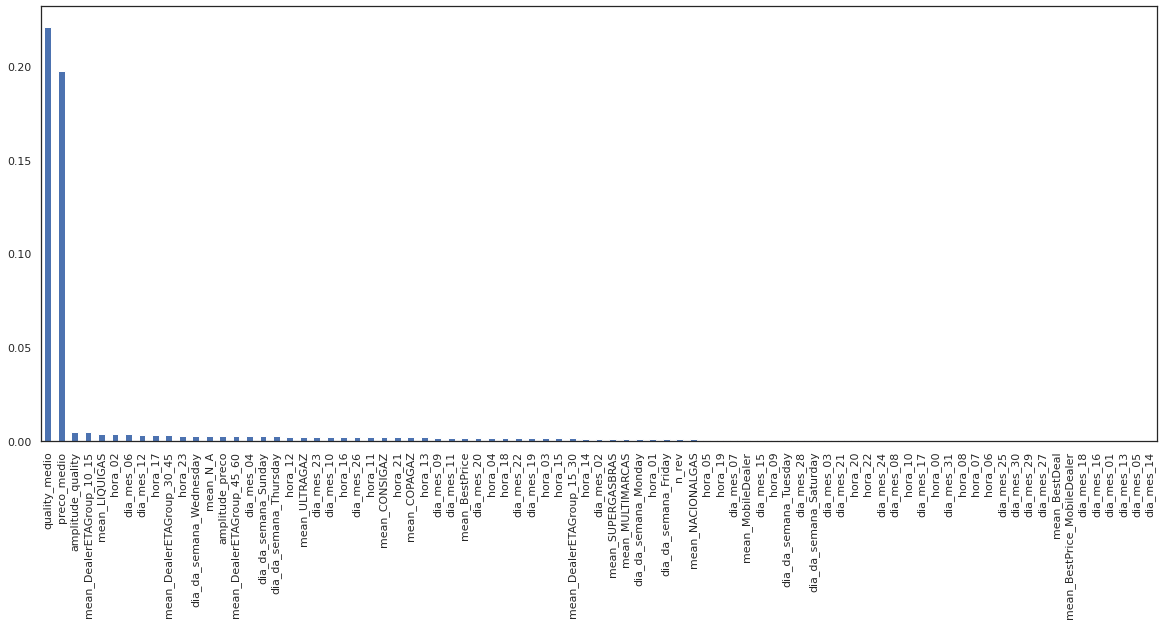

In [ ]:
# Ranking da variáveis explicativas por gráfico
mi.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [ ]:
# Selecionando 30% das 66 variáveis do dataframe do modelo (tdf) conforme o ranking
#sel_ = SelectPercentile(mutual_info_regression, percentile=60).fit(X_train.fillna(0), y_train)
#df_var_mod = X_train.columns[sel_.get_support()]

In [ ]:
# Listando 30% as variáveis importantes
#df_var_mod

In [ ]:
mi.sort_values(ascending=False)

quality_medio                  0.220781
preco_medio                    0.197341
amplitude_quality              0.004739
mean_DealerETAGroup_10_15      0.004680
mean_LIQUIGAS                  0.003752
hora_02                        0.003591
dia_mes_06                     0.003570
dia_mes_12                     0.003475
hora_17                        0.003415
mean_DealerETAGroup_30_45      0.003242
hora_23                        0.002975
dia_da_semana_Wednesday        0.002967
mean_N_A                       0.002933
amplitude_preco                0.002820
mean_DealerETAGroup_45_60      0.002717
dia_mes_04                     0.002625
dia_da_semana_Sunday           0.002508
dia_da_semana_Thursday         0.002503
hora_12                        0.002455
mean_ULTRAGAZ                  0.002424
dia_mes_23                     0.002338
dia_mes_10                     0.002286
hora_16                        0.002263
dia_mes_26                     0.002251
hora_11                        0.002226


In [ ]:
# dropando da base dfmod variáveis consideradas pelo modelo MI sem informação
cols_to_drop = ['dia_mes_31',
                'hora_08',
                'dia_mes_25',
                'hora_07',
                'hora_06',
                'dia_mes_30',
                'dia_mes_29',
                'dia_mes_27',
                'mean_BestDeal',
                'mean_BestPrice_MobileDealer',
                'dia_mes_18',
                'dia_mes_16',
                'dia_mes_01',
                'dia_mes_13',
                'dia_mes_05',
                'dia_mes_14']
dfmod = dfmod.drop(cols_to_drop, axis=1)

### Matriz de Correlação

In [ ]:
# Criando um mapa de calor entre os atributos 

def multi_collinearity_heatmap(df, figsize=(11,9)):    
    # Estilo de Visualização
    sns.set(style="white")
    # Matriz de Correlação 
    corr = df.corr()
    # Mascara de tamanho da matriz de correlação 
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Configuração do tamanho do gráfico 
    f, ax = plt.subplots(figsize=figsize)
    # Mapas de cores
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Definido o mapa de calor com a proporção correta
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

<Figure size 1800x864 with 0 Axes>

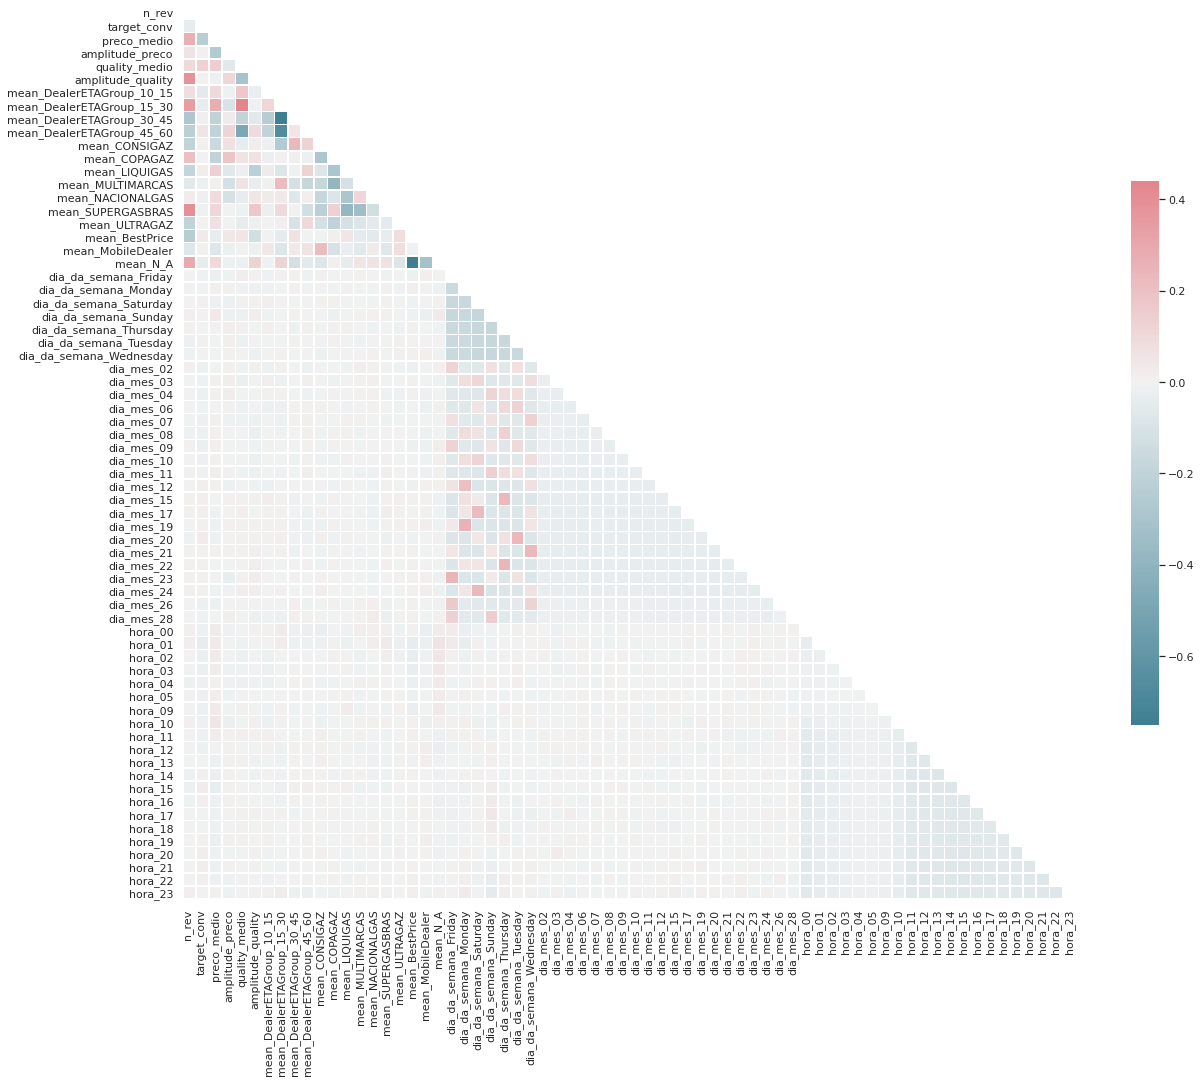

In [ ]:
plt.figure(figsize=(25,12))
multi_collinearity_heatmap(dfmod, figsize=(20,20))

# Modelo Preditivo

In [ ]:
# Separando o conjunto de dados treinamento e teste

X_train, X_test, y_train, y_test = train_test_split(dfmod.drop('target_conv', axis=1),dfmod['target_conv'], test_size=0.2, random_state=0)

In [ ]:
# Balanceado o conjunto de dados - grupo controle e grupo tratamento

import random
pos_index = y_train[y_train.values == 1].index
neg_index = y_train[y_train.values == 0].index
if len(pos_index) > len(neg_index):
  higher = pos_index
  lower = neg_index
else:
  higher = neg_index
  lower = pos_index
random.seed(0)
higher = np.random.choice(higher, size=len(lower))
lower = np.asarray(lower)
new_indexes = np.concatenate((lower, higher))
X_train = X_train.loc[new_indexes,]
y_train = y_train[new_indexes]

In [ ]:
y_train.value_counts()

1    1707
0    1707
Name: target_conv, dtype: int64

In [ ]:
X_train.value_counts()

n_rev  preco_medio  amplitude_preco  quality_medio  amplitude_quality  mean_DealerETAGroup_10_15  mean_DealerETAGroup_15_30  mean_DealerETAGroup_30_45  mean_DealerETAGroup_45_60  mean_CONSIGAZ  mean_COPAGAZ  mean_LIQUIGAS  mean_MULTIMARCAS  mean_NACIONALGAS  mean_SUPERGASBRAS  mean_ULTRAGAZ  mean_BestPrice  mean_MobileDealer  mean_N_A  dia_da_semana_Friday  dia_da_semana_Monday  dia_da_semana_Saturday  dia_da_semana_Sunday  dia_da_semana_Thursday  dia_da_semana_Tuesday  dia_da_semana_Wednesday  dia_mes_02  dia_mes_03  dia_mes_04  dia_mes_06  dia_mes_07  dia_mes_08  dia_mes_09  dia_mes_10  dia_mes_11  dia_mes_12  dia_mes_15  dia_mes_17  dia_mes_19  dia_mes_20  dia_mes_21  dia_mes_22  dia_mes_23  dia_mes_24  dia_mes_26  dia_mes_28  hora_00  hora_01  hora_02  hora_03  hora_04  hora_05  hora_09  hora_10  hora_11  hora_12  hora_13  hora_14  hora_15  hora_16  hora_17  hora_18  hora_19  hora_20  hora_21  hora_22  hora_23
15     72.111334    16.00            4.584497       0.682353           0

In [ ]:
# Separando o conjunto de dados treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=0.2, random_state=0)

In [ ]:
from sklearn.preprocessing import StandardScaler
# Scaling
scaler = StandardScaler()
X_train= pd.DataFrame(scaler.fit_transform(X_train), columns=list(X_train.columns))
X_test= pd.DataFrame(scaler.fit_transform(X_test), columns=list(X_test.columns))

In [ ]:
X_train.value_counts()

n_rev      preco_medio  amplitude_preco  quality_medio  amplitude_quality  mean_DealerETAGroup_10_15  mean_DealerETAGroup_15_30  mean_DealerETAGroup_30_45  mean_DealerETAGroup_45_60  mean_CONSIGAZ  mean_COPAGAZ  mean_LIQUIGAS  mean_MULTIMARCAS  mean_NACIONALGAS  mean_SUPERGASBRAS  mean_ULTRAGAZ  mean_BestPrice  mean_MobileDealer  mean_N_A   dia_da_semana_Friday  dia_da_semana_Monday  dia_da_semana_Saturday  dia_da_semana_Sunday  dia_da_semana_Thursday  dia_da_semana_Tuesday  dia_da_semana_Wednesday  dia_mes_02  dia_mes_03  dia_mes_04  dia_mes_06  dia_mes_07  dia_mes_08  dia_mes_09  dia_mes_10  dia_mes_11  dia_mes_12  dia_mes_15  dia_mes_17  dia_mes_19  dia_mes_20  dia_mes_21  dia_mes_22  dia_mes_23  dia_mes_24  dia_mes_26  dia_mes_28  hora_00    hora_01    hora_02    hora_03    hora_04    hora_05    hora_09    hora_10    hora_11    hora_12    hora_13    hora_14    hora_15    hora_16    hora_17    hora_18    hora_19    hora_20    hora_21    hora_22    hora_23  
-0.237956   0.295525    -

In [ ]:
# summarize the dataset
print(X_train.shape,X_test.shape)

(2731, 67) (683, 67)


In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print("Matriz Confusão \n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Matriz Confusão 
 [[256  87]
 [ 94 246]]
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       343
           1       0.74      0.72      0.73       340

    accuracy                           0.73       683
   macro avg       0.74      0.73      0.73       683
weighted avg       0.74      0.73      0.73       683



In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

In [ ]:
accuracies

array([0.7189781 , 0.75091575, 0.73626374, 0.68864469, 0.6996337 ,
       0.71794872, 0.6996337 , 0.70695971, 0.74725275, 0.71428571])

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
rfe = RFE(classifier, 30) # definir o número de variáveis a serem consideradas
rfe = rfe.fit(X_train, y_train)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

rfe = RFE(classifier, 19)
rfe = rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True False  True False False  True  True  True False
  True False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False  True  True  True False False False False False False False  True
 False False False  True  True  True  True]
[ 1  1  1  1 24  1 46 23  1  1  1 14  1 20 18 19 39 49 27 32 40 28  1 30
 31 29 21 34 12 45 44 48 33 22 25 42 37 26 41  1 36 38 47 43 13 17  4 15
 16  1  1  1 35  7 11 10  8  2  3  1  6  9  5  1  1  1  1]


In [ ]:
print(rfe.ranking_)

[ 1  1  1  1 24  1 46 23  1  1  1 14  1 20 18 19 39 49 27 32 40 28  1 30
 31 29 21 34 12 45 44 48 33 22 25 42 37 26 41  1 36 38 47 43 13 17  4 15
 16  1  1  1 35  7 11 10  8  2  3  1  6  9  5  1  1  1  1]


In [ ]:
classifier.fit(X_train[X_train.columns[rfe.support_]], y_train)
y_pred = classifier.predict(X_test[X_train.columns[rfe.support_]])

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)
f1_score(y_test, y_pred)

0.7302052785923755

In [ ]:
print("Matriz Confusão \n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Matriz Confusão 
 [[250  93]
 [ 91 249]]
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       343
           1       0.73      0.73      0.73       340

    accuracy                           0.73       683
   macro avg       0.73      0.73      0.73       683
weighted avg       0.73      0.73      0.73       683



In [ ]:
pd.concat([pd.DataFrame(X_train.columns, columns = ['features']), pd.DataFrame(np.transpose(classifier.coef_), columns = ['coef'])],axis = 1)

,features,coef
0,n_rev,0.175551
1,preco_medio,-1.129107
2,amplitude_preco,-0.244480
3,quality_medio,0.627424
4,amplitude_quality,-0.231195
5,mean_DealerETAGroup_10_15,0.205789
6,mean_DealerETAGroup_15_30,-0.297694
7,mean_DealerETAGroup_30_45,-0.387567
8,mean_DealerETAGroup_45_60,-0.255050
9,mean_CONSIGAZ,0.129686


SyntaxError: ignored